## LABORATORIO 6 
Ignacio Méndez Alvarez (22613) y Diego Soto Flores (22737)

In [ ]:
import pandas as pd
import unicodedata
import string
import nltk
import re
from nltk.corpus import stopwords
from collections import Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import networkx as nx

import community as community_louvain 
import collections

import json, pandas as pd

# ----- Análisis de tópicos con LDA (sklearn) -----
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pytz


In [6]:
txt = open('traficogt.txt','rb').read().decode('utf-16', errors='ignore')

# Extrae objetos JSON balanceando llaves y respetando strings
objs, i, n, depth, start, in_str, esc = [], 0, len(txt), 0, None, False, False
while i < n:
    c = txt[i]
    if in_str:
        if esc: esc = False
        elif c == '\\': esc = True
        elif c == '"': in_str = False
    else:
        if c == '"': in_str = True
        elif c == '{':
            if depth == 0: start = i
            depth += 1
        elif c == '}':
            if depth: depth -= 1
            if depth == 0 and start is not None:
                objs.append(txt[start:i+1]); start = None
    i += 1

# Helpers cortos
jh = lambda hs: ', '.join([h if isinstance(h,str) else (h.get('text') or h.get('tag') or h.get('name','')) for h in (hs or []) if h])
jm = lambda ms: ', '.join([m if isinstance(m,str) else (m.get('username') or m.get('displayname','')) for m in (ms or []) if m])

# Parseo y filtrado de columnas
rows = []
for s in objs:
    try:
        o = json.loads(s)
        u = o.get('user') or {}

        # --- respuesta ---
        reply_to = None
        if o.get("inReplyToUser"):
            reply_to = o["inReplyToUser"].get("username")

        # --- retweet ---
        retweeted_user = None
        if o.get("retweetedTweet") and o["retweetedTweet"].get("user"):
            retweeted_user = o["retweetedTweet"]["user"].get("username")

        rows.append({
            'username': u.get('username'),
            'date': o.get('date'),
            'rawContent': o.get('rawContent'),
            'replyCount': o.get('replyCount'),
            'retweetCount': o.get('retweetCount'),
            'likeCount': o.get('likeCount'),
            'hashtags': jh(o.get('hashtags')),
            'mentionUsers': jm(o.get('mentionedUsers')),
            'viewCount': o.get('viewCount'),
            "reply_to": reply_to,
            "retweeted_user": retweeted_user
        })
    except Exception:
        pass  # ignora objetos corruptos

cols = ["username","date","rawContent", "replyCount","retweetCount","likeCount","hashtags","mentionUsers","viewCount","reply_to","retweeted_user"]
df = pd.DataFrame(rows)[cols]

In [7]:
df

,username,date,rawContent,replyCount,retweetCount,likeCount,hashtags,mentionUsers,viewCount,reply_to,retweeted_user
0,traficogt,2024-09-12 14:22:06+00:00,Es comprensible la resolución... El ruso sabe ...,0,0,1,,,393.0,None,None
1,monymmorales,2024-09-12 00:39:56+00:00,La corrupción de la @CC_Guatemala\nes descarad...,0,56,84,,CC_Guatemala,1587.0,None,None
2,animaldgalaccia,2024-09-12 01:21:04+00:00,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,0,0,1,,"PNCdeGuatemala, mingobguate, FJimenezmingob, d...",91.0,PNCdeGuatemala,None
3,EstacionDobleA,2024-09-11 20:20:01+00:00,@amilcarmontejo @AztecaNoticiaGT @BancadaSemil...,0,0,0,,"amilcarmontejo, AztecaNoticiaGT, BancadaSemill...",46.0,EstacionDobleA,None
4,CubReserva,2024-09-11 00:34:31+00:00,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,0,0,1,,"soy_502, AztecaNoticiaGT, CONAPgt, DenunciaEMP...",171.0,CubReserva,None
...,...,...,...,...,...,...,...,...,...,...,...
5599,guiselabarrios,2023-10-08 21:58:09+00:00,@traficogt Y no que presentando 5 mil firmas a...,0,0,0,,traficogt,8.0,traficogt,None
5600,mvtrooper,2023-10-08 21:37:45+00:00,@hshetemul @traficogt Y de igual Manera quitan...,0,0,0,,"hshetemul, traficogt, MPguatemala, CangGuatemala",3.0,hshetemul,None
5601,elmeronene1,2023-10-08 21:37:19+00:00,@traficogt Es algo más fuerte que ellos no qui...,0,0,0,,traficogt,21.0,traficogt,None
5602,mvtrooper,2023-10-08 21:31:24+00:00,@Factor4_GT @traficogt @CC_Guatemala @MPguatem...,0,0,0,,"Factor4_GT, traficogt, CC_Guatemala, MPguatemala",4.0,Factor4_GT,None


In [8]:
df.info()
display(df.head())
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5604 entries, 0 to 5603
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   username        5604 non-null   object 
 1   date            5604 non-null   object 
 2   rawContent      5604 non-null   object 
 3   replyCount      5604 non-null   int64  
 4   retweetCount    5604 non-null   int64  
 5   likeCount       5604 non-null   int64  
 6   hashtags        5604 non-null   object 
 7   mentionUsers    5604 non-null   object 
 8   viewCount       5600 non-null   float64
 9   reply_to        4150 non-null   object 
 10  retweeted_user  0 non-null      object 
dtypes: float64(1), int64(3), object(7)
memory usage: 481.7+ KB


,username,date,rawContent,replyCount,retweetCount,likeCount,hashtags,mentionUsers,viewCount,reply_to,retweeted_user
0,traficogt,2024-09-12 14:22:06+00:00,Es comprensible la resolución... El ruso sabe ...,0,0,1,,,393.0,None,None
1,monymmorales,2024-09-12 00:39:56+00:00,La corrupción de la @CC_Guatemala\nes descarad...,0,56,84,,CC_Guatemala,1587.0,None,None
2,animaldgalaccia,2024-09-12 01:21:04+00:00,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,0,0,1,,"PNCdeGuatemala, mingobguate, FJimenezmingob, d...",91.0,PNCdeGuatemala,None
3,EstacionDobleA,2024-09-11 20:20:01+00:00,@amilcarmontejo @AztecaNoticiaGT @BancadaSemil...,0,0,0,,"amilcarmontejo, AztecaNoticiaGT, BancadaSemill...",46.0,EstacionDobleA,None
4,CubReserva,2024-09-11 00:34:31+00:00,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,0,0,1,,"soy_502, AztecaNoticiaGT, CONAPgt, DenunciaEMP...",171.0,CubReserva,None


username             0
date                 0
rawContent           0
replyCount           0
retweetCount         0
likeCount            0
hashtags             0
mentionUsers         0
viewCount            4
reply_to          1454
retweeted_user    5604
dtype: int64

In [14]:

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

SPANISH_STOPWORDS = set(stopwords.words('spanish')).union({'ma', 'si'})

# definimos regex según acción por hacer. 
URL_RE = re.compile(r'https?://\S+|www\.\S+', re.IGNORECASE)
MENTION_RE = re.compile(r'@([A-Za-z0-9_]{1,15})')  # handle básico de X
HASHTAG_RE = re.compile(r'#(\w+)')
EMOJI_RE = re.compile(r'[\U00010000-\U0010ffff]', flags=re.UNICODE)


# funciones para parsear cada item de cada tweet. 
def normalize_username(u):
    if pd.isna(u):
        return u
    return str(u).strip().lower()

def clean_text(text: str):
    if pd.isna(text):
        return ''
    t = text
    t = URL_RE.sub(' ', t)
    t = EMOJI_RE.sub(' ', t)
    t = t.lower()
    t = unicodedata.normalize('NFKD', t)
    t = ''.join(ch for ch in t if not unicodedata.combining(ch))
    t = t.translate(str.maketrans('', '', string.punctuation))
    t = re.sub(r'\d+', ' ', t)
    tokens = [w for w in re.findall(r'\b\w+\b', t) if w not in SPANISH_STOPWORDS]
    return ' '.join(tokens)

# devuelve una lista de todas las menciones (@) encontradas en el tweet. 
def extract_mentions(text: str):
    return [m.lower() for m in MENTION_RE.findall(text or '')]

# devuelve una lista de todos los hashtags (#) encontradas en el tweet. 
def extract_hashtags(text: str):
    return [h.lower() for h in HASHTAG_RE.findall(text or '')]

# si empieza con "rt" lo marca como retweet. 
def is_retweet(text: str):
    return bool(re.match(r'^\s*rt\s*@', str(text).lower()))

# si empieza con "@usuario" lo marca como reply. 
def is_reply(text: str):
    return bool(re.match(r'^\s*@', str(text).lower()))

df['username'] = df['username'].map(normalize_username)
df['tweet_text_clean'] = df['rawContent'].map(clean_text)
df['mentions'] = df['rawContent'].map(extract_mentions)
df['hashtags'] = df['rawContent'].map(extract_hashtags)
df['is_retweet'] = df['rawContent'].map(is_retweet)
df['is_reply'] = df['rawContent'].map(is_reply)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['reply_to'] = df['reply_to'].map(normalize_username)
df['retweeted_user'] = df['retweeted_user'].map(normalize_username)

# Eliminar duplicados por texto y usuario en el mismo instante
df = df.drop_duplicates(subset=['username','rawContent','date']).reset_index(drop=True)
display(df.head())

,username,date,rawContent,replyCount,retweetCount,likeCount,hashtags,mentionUsers,viewCount,reply_to,retweeted_user,tweet_text_clean,mentions,is_retweet,is_reply
0,traficogt,2024-09-12 14:22:06+00:00,Es comprensible la resolución... El ruso sabe de engrasar maquinaria.,0,0,1,[],,393.0,None,None,comprensible resolucion ruso sabe engrasar maquinaria,[],False,False
1,monymmorales,2024-09-12 00:39:56+00:00,"La corrupción de la @CC_Guatemala\nes descarada, falsificación de documentos y obligaron a extenderles DPI.\nhttps://t.co/0J24ZCXJ2c",0,56,84,[],CC_Guatemala,1587.0,None,None,corrupcion ccguatemala descarada falsificacion documentos obligaron extenderles dpi,[cc_guatemala],False,False
2,animaldgalaccia,2024-09-12 01:21:04+00:00,@PNCdeGuatemala @mingobguate @FJimenezmingob @diegoedeleon @amilcarmontejo @traficogt \n\n🚨🚨🚨🚨🚨,0,0,1,[],"PNCdeGuatemala, mingobguate, FJimenezmingob, diegoedeleon, amilcarmontejo, traficogt",91.0,pncdeguatemala,None,pncdeguatemala mingobguate fjimenezmingob diegoedeleon amilcarmontejo traficogt,"[pncdeguatemala, mingobguate, fjimenezmingob, diegoedeleon, amilcarmontejo, traficogt]",False,True
3,estaciondoblea,2024-09-11 20:20:01+00:00,@amilcarmontejo @AztecaNoticiaGT @BancadaSemilla @BArevalodeLeon @diputadojp @EmisorasUnidas @eP_investiga @ImpactoNoticiGT @lahoragt @mingobguate @PrensaComunitar @Transito_mixco @DGTguate @PMT_VILLANUEVA @InfoTransitoGt @traficogt @PMT_SanJuanSac @PMTSanLucasSac @YenerPlaza,0,0,0,[],"amilcarmontejo, AztecaNoticiaGT, BancadaSemilla, BArevalodeLeon, diputadojp, EmisorasUnidas, eP_investiga, ImpactoNoticiGT, lahoragt, mingobguate, PrensaComunitar, Transito_mixco, DGTguate, PMT_VILLANUEVA, InfoTransitoGt, traficogt, PMT_SanJuanSac, PMTSanLucasSac, YenerPlaza",46.0,estaciondoblea,None,amilcarmontejo aztecanoticiagt bancadasemilla barevalodeleon diputadojp emisorasunidas epinvestiga impactonoticigt lahoragt mingobguate prensacomunitar transitomixco dgtguate pmtvillanueva infotransitogt traficogt pmtsanjuansac pmtsanlucassac yenerplaza,"[amilcarmontejo, aztecanoticiagt, bancadasemilla, barevalodeleon, diputadojp, emisorasunidas, ep_investiga, impactonoticigt, lahoragt, mingobguate, prensacomunitar, transito_mixco, dgtguate, pmt_villanueva, infotransitogt, traficogt, pmt_sanjuansac, pmtsanlucassac, yenerplaza]",False,True
4,cubreserva,2024-09-11 00:34:31+00:00,"@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEMPAGUA @muniguate @GuatemalaGob @Guatevision_tv @pattyo502 @karinapazGt @Josechic86 @vecinosz16 URGENTE zona 16 en deterioro por tala inmoderada, el tráfico es desesperante @traficogt @EmisorasUnidas @eP_investiga @IsaPaiz_",0,0,1,[],"soy_502, AztecaNoticiaGT, CONAPgt, DenunciaEMPAGUA, muniguate, GuatemalaGob, Guatevision_tv, pattyo502, karinapazGt, Josechic86, vecinosz16, traficogt, EmisorasUnidas, eP_investiga, IsaPaiz_",171.0,cubreserva,None,aztecanoticiagt conapgt denunciaempagua muniguate guatemalagob guatevisiontv pattyo karinapazgt josechic vecinosz urgente zona deterioro tala inmoderada trafico desesperante traficogt emisorasunidas epinvestiga isapaiz,"[soy_502, aztecanoticiagt, conapgt, denunciaempagua, muniguate, guatemalagob, guatevision_tv, pattyo502, karinapazgt, josechic86, vecinosz16, traficogt, emisorasunidas, ep_investiga, isapaiz_]",False,True


In [15]:
pd.set_option("display.max_colwidth", None)
df[['rawContent', 'tweet_text_clean']].head(20)   # muestra las primeras 20 filas

,rawContent,tweet_text_clean
0,Es comprensible la resolución... El ruso sabe de engrasar maquinaria.,comprensible resolucion ruso sabe engrasar maquinaria
1,"La corrupción de la @CC_Guatemala\nes descarada, falsificación de documentos y obligaron a extenderles DPI.\nhttps://t.co/0J24ZCXJ2c",corrupcion ccguatemala descarada falsificacion documentos obligaron extenderles dpi
2,@PNCdeGuatemala @mingobguate @FJimenezmingob @diegoedeleon @amilcarmontejo @traficogt \n\n🚨🚨🚨🚨🚨,pncdeguatemala mingobguate fjimenezmingob diegoedeleon amilcarmontejo traficogt
3,@amilcarmontejo @AztecaNoticiaGT @BancadaSemilla @BArevalodeLeon @diputadojp @EmisorasUnidas @eP_investiga @ImpactoNoticiGT @lahoragt @mingobguate @PrensaComunitar @Transito_mixco @DGTguate @PMT_VILLANUEVA @InfoTransitoGt @traficogt @PMT_SanJuanSac @PMTSanLucasSac @YenerPlaza,amilcarmontejo aztecanoticiagt bancadasemilla barevalodeleon diputadojp emisorasunidas epinvestiga impactonoticigt lahoragt mingobguate prensacomunitar transitomixco dgtguate pmtvillanueva infotransitogt traficogt pmtsanjuansac pmtsanlucassac yenerplaza
4,"@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEMPAGUA @muniguate @GuatemalaGob @Guatevision_tv @pattyo502 @karinapazGt @Josechic86 @vecinosz16 URGENTE zona 16 en deterioro por tala inmoderada, el tráfico es desesperante @traficogt @EmisorasUnidas @eP_investiga @IsaPaiz_",aztecanoticiagt conapgt denunciaempagua muniguate guatemalagob guatevisiontv pattyo karinapazgt josechic vecinosz urgente zona deterioro tala inmoderada trafico desesperante traficogt emisorasunidas epinvestiga isapaiz
5,"@amilcarmontejo @PMTMuniGuate @Noti7Guatemala @NuestroDiario @T13Noticias @AztecaGuate @traficogt hay avenidas y calles (11 avenida 8 a la 12 calle) sin luz, semáforo y sin agentes de emetra .",amilcarmontejo pmtmuniguate noti guatemala nuestrodiario t noticias aztecaguate traficogt avenidas calles avenida calle luz semaforo agentes emetra
6,Favor compartir \nEl vive el zona 7 Bethania \n@traficogt @amilcarmontejo @PNCdeGuatemala #urgente #Desaparecido https://t.co/LcIJv0Ffsj,favor compartir vive zona bethania traficogt amilcarmontejo pncdeguatemala urgente desaparecido
7,@traficogt @_ojoconmipisto @soy_502 @AztecaNoticiaGT @AztecaNoticiaGT @muniguate @CONAPgt @DenunciaEMPAGUA @EmisorasUnidas @eP_investiga @luisvengt @samuel_pz @Josechic86 @CiudadCayala @marnguate @karinapazGt @vecinosz16 es importante ponerle atención a los vecinos de z 16 https://t.co/vRDMtvj36F,traficogt ojoconmipisto aztecanoticiagt aztecanoticiagt muniguate conapgt denunciaempagua emisorasunidas epinvestiga luisvengt samuelpz josechic ciudadcayala marnguate karinapazgt vecinosz importante ponerle atencion vecinos z
8,@piero_coen @FJimenezmingob @traficogt @mingobguate @PNCdeGuatemala @DiariodeCA @AGN_noticias @Radio_TGW @GuatemalaGob Son pajas la mota ahora ya no vale nada,pierocoen fjimenezmingob traficogt mingobguate pncdeguatemala diariodeca agnnoticias radiotgw guatemalagob pajas mota ahora vale
9,"@erwin_fern84019 @piero_coen @FJimenezmingob @traficogt @mingobguate @PNCdeGuatemala @DiariodeCA @AGN_noticias @Radio_TGW @GuatemalaGob ayyyy te arde que fumen mota, mejor segui chimando bebes.",erwinfern pierocoen fjimenezmingob traficogt mingobguate pncdeguatemala diariodeca agnnoticias radiotgw guatemalagob ayyyy arde fumen mota mejor segui chimando bebes


### Exploratorio

In [16]:
num_tweets = len(df)
num_usuarios = df['username'].nunique()
num_menciones = df['mentions'].map(len).sum()
all_hashtags = [h for hs in df['hashtags'] for h in hs]
num_hashtags = len(all_hashtags)

print('Tweets:', num_tweets)
print('Usuarios únicos:', num_usuarios)
print('Total de menciones:', num_menciones)
print('Total de hashtags:', num_hashtags)

top_mentions = Counter([m for ms in df['mentions'] for m in ms]).most_common(10)
top_hashtags = Counter(all_hashtags).most_common(10)
print('\nTop menciones:', top_mentions)
print('Top hashtags:', top_hashtags)

Tweets: 5596
Usuarios únicos: 2071
Total de menciones: 11009
Total de hashtags: 592

Top menciones: [('traficogt', 4239), ('barevalodeleon', 433), ('drgiammattei', 175), ('amilcarmontejo', 166), ('prensacomunitar', 162), ('mpguatemala', 139), ('mmendoza_gt', 131), ('lahoragt', 128), ('cc_guatemala', 110), ('muniguate', 98)]
Top hashtags: [('ahora', 30), ('guatemala', 25), ('ahoralh', 19), ('urgente', 16), ('traficogt', 16), ('renunciengolpistas', 15), ('lahoradeactualizarnos', 8), ('guateresiste', 8), ('paronacionalindefinido', 8), ('paronacionaindefinido', 8)]


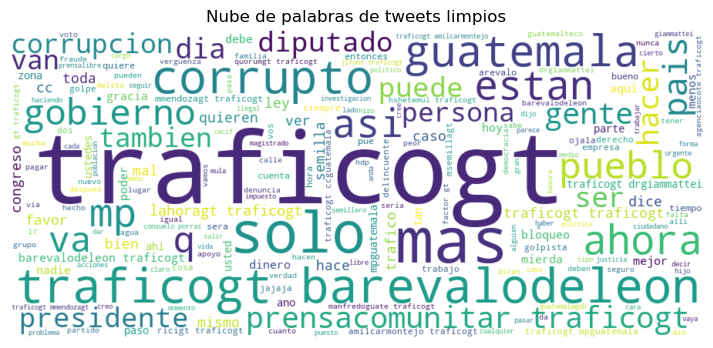

In [17]:
text_for_wc = ' '.join(df['tweet_text_clean'].tolist())
wc = WordCloud(width=900, height=400, background_color='white').generate(text_for_wc)
plt.figure(figsize=(10,4))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de tweets limpios')
plt.show()

In [18]:
# Diccionario de palabras y frecuencias relativas
frecuencias = wc.words_
print(type(frecuencias))
print(list(frecuencias.items())[:10])

<class 'dict'>
[('traficogt', 1.0), ('mas', 0.2769640479360852), ('solo', 0.2210386151797603), ('traficogt barevalodeleon', 0.1804260985352863), ('corrupto', 0.1711051930758988), ('guatemala', 0.15046604527296936), ('ahora', 0.12916111850865514), ('estan', 0.1284953395472703), ('asi', 0.12250332889480692), ('mp', 0.12117177097203728)]


#### Preguntas



1. ¿Cuáles son las horas del día con mayor cantidad de reportes de tráfico?
2. ¿Cuáles son los días de la semana con mayor actividad en los reportes de tráfico?
3. ¿Qué cuentas de Twitter son las más mencionadas en los reportes de tráfico?

In [27]:
import pandas as pd


df['date'] = pd.to_datetime(df['date'], errors='coerce')

gt_tz = pytz.timezone('America/Guatemala')

if df['date'].dt.tz is None:
    df['date_local'] = df['date'].dt.tz_localize('UTC').dt.tz_convert(gt_tz)
else:
    df['date_local'] = df['date'].dt.tz_convert(gt_tz)

horas = (
    df.dropna(subset=['date_local'])
      .assign(hora=lambda x: x['date_local'].dt.hour)
      .groupby('hora', as_index=False)
      .size()
      .rename(columns={'size': 'tweets'})
      .sort_values('tweets', ascending=False)
      .reset_index(drop=True)
)

print(horas.head(10))



   hora  tweets
0    18     404
1    13     388
2    14     387
3    17     383
4    19     363
5    15     343
6     8     322
7    16     322
8    12     318
9     7     312


La hora más comun en la que los usuarios escriben sobre el trafico de Guatemala es justamente a las horas pico, que en este caso son a medio dia (1-2pm) y en la tarde (5-6pm)

In [22]:
dias_map = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}

dias = (
    df.dropna(subset=['date'])
      .assign(dow=df['date'].dt.dayofweek,
              dia=lambda x: x['dow'].map(dias_map))
      .groupby(['dow','dia'], as_index=False)
      .size()
      .rename(columns={'size': 'tweets'})
      .sort_values(['tweets'], ascending=False)
)

dias_por_orden_semana = dias.sort_values('dow').drop(columns='dow')
dias_por_orden_semana



,dia,tweets
0,Lunes,826
1,Martes,1081
2,Miércoles,882
3,Jueves,867
4,Viernes,719
5,Sábado,583
6,Domingo,638


Analizando los días en los que hay más tweets se puede ver que los dias entre semana son los que tienen más tweets, siendo el día martes el más alto. Cabe recalcar que fin de semana la cantidad de tweets baja un poco pero no tanto comparado a entre semana.

In [24]:
top_n = 10 
cuentas = (
    df.dropna(subset=['username'])
      .assign(username=lambda x: x['username'].str.lower().str.strip())
      .groupby('username', as_index=False)
      .size()
      .rename(columns={'size': 'tweets'})
      .sort_values('tweets', ascending=False)
)

cuentas_top = cuentas.head(top_n)
cuentas_top


,username,tweets
1939,traficogt,781
225,batallonjalapa,133
1449,mildred_gaitan,103
1187,lahoragt,72
385,chofito63569841,47
160,angeln8,46
1657,prensacomunitar,40
911,hellboy17oc,39
1597,papaabumario,36
90,alejandro2024gt,33


Analizando los usuarios con más tweets traficogt es la cuenta que predomina y por mucho, ya que tiene 781 tweets y la segunda cuenta más popular es batallonjalapa con 133. Es comprensible que traficogt tenga tanta ventaja ya que se encargan de reportar cualquier tema relacionado con el trafico.